## This is my attempt at implementing the RouBl algorithm

In [1]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp


EPS = 1e-5  # define a small constant for numerical stability control

In [39]:
class FullCovGaussianNetwork(nn.Module):
    def __init__(self, layer_sizes, prior_std=0.1, init_std=0.1, alpha=0.1, gamma=1,
                 sqrt_width_scaling=False, device=None, dtype=None):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FullCovGaussianNetwork, self).__init__()

        self.layer_sizes = layer_sizes  # dimension of network layer input 
        self.dim_in = layer_sizes[0]
        self.dim_out = layer_sizes[-1]
        self.alpha = alpha
        self.gamma = gamma
        n = sum(dim_in * dim_out + dim_out for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:]))
        self.num_params = n

        # define and initialise the trainable variational parameters for q distribtuion
        self.mean = nn.Parameter(torch.zeros(n, **factory_kwargs), requires_grad=True)
        self.cov_chol = nn.Parameter(torch.diag(prior_std*torch.ones(n, **factory_kwargs)).detach().clone().requires_grad_(True))

        cov_chol_inv = torch.linalg.inv(self.cov_chol).detach()
        self.lambda_1 = (cov_chol_inv @ torch.transpose(cov_chol_inv, 0, 1) @ self.mean).clone().detach()
        
        # self.reset_parameters(init_std)

        # define the prior parameters (for prior p, assume the mean is 0)
        prior_mean = 0.0
        if sqrt_width_scaling:  # prior variance scales as 1/dim_in
            prior_param_std /= self.dim_in ** 0.5
            
        self.prior_std = prior_std

        # prior parameters are registered as constants
        self.register_buffer('prior_mean', torch.zeros(self.num_params, **factory_kwargs))
        self.register_buffer('prior_cov_chol', torch.diag(prior_std*torch.ones(n, **factory_kwargs)))
        self.register_buffer('prior_cov_inv', torch.diag(1/prior_std**2 * torch.ones(n, **factory_kwargs)))

    # I don't know what this is doing
    # def reset_parameters(self, init_std=0.5):
    #     nn.init.kaiming_uniform_(self.weight_mean, a=math.sqrt(5))
    #     bound = self.dim_in ** -0.5
    #     nn.init.uniform_(self.bias_mean, -bound, bound)
    #     _init_std_param = math.log(math.expm1(init_std))
    #     self._cov_diag.data = torch.full_like(self._cov_diag.data, _init_std_param)
    #     self._cov_tril.data = torch.full_like(self._cov_tril.data, 0.0)

    # define the q distribution standard deviations with property decorator#
   
    # @property
    # def scale_tril(self):
    #     # this returns the cholesky decomposition L of the covariance: Cov = LL^T
        
    #     # Only taking values below the main diagonal? no it takes everything below diagonal
    #     return F.softplus(self._cov_diag).diagflat() + torch.tril(self._cov_tril, diagonal=-1)


    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.cov_chol)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_cov_chol)
        kl = dist.kl_divergence(q, p).sum()
        return kl

   
    def sample_params(self):
        # Sample from q distribution and ensure requires_grad=True
        sample = self.mean + self.cov_chol @ torch.randn_like(self.mean)
        sample = sample.detach().requires_grad_(True)  # Ensure gradients can be computed
        return sample

    def forward(self, input, sampled_params):
        # Forward pass using the sampled parameters
        start = 0
        for i, (dim_in, dim_out) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            end = start + dim_out * dim_in
            weight = sampled_params[start:end].view(dim_out, dim_in)
            start = end
            end = start + dim_out
            bias = sampled_params[start:end]
            start = end
            input = F.linear(input, weight, bias)
            if i < len(self.layer_sizes) - 2:
                input = F.leaky_relu(input)
        return input

# Example usage
net = FullCovGaussianNetwork([1, 2, 2, 1], prior_std=0.1, init_std=0.1)
input_data = torch.tensor(([1.0], [1.5]), requires_grad=False)
targets = torch.tensor(([2.0], [2.1]), requires_grad=False)



In [5]:
# # Function to compute gradients for each data point
# def compute_pointwise_gradients(net, input_data):
#     all_grads = []
    
#     # Sample the parameters with requires_grad=True
#     sampled_params = net.sample_params()
    
#     # Loop over each data point in the input batch
#     for i in range(input_data.size(0)):
#         input_point = input_data[i:i+1]  # Select a single input point (batch size 1)
        
#         # Zero out previous gradients (important to reset before each backward pass)
#         if sampled_params.grad is not None:
#             sampled_params.grad.zero_()
        
#         # Forward pass
#         output = net.forward(input_point, sampled_params)
        
#         # Backward pass to calculate the gradients for this specific data point
#         output.backward(torch.ones_like(output))  # Using 1s to backpropagate for each output
        
#         # Store the gradient for this data point
#         grads = sampled_params.grad.clone().detach()  # Clone and detach to avoid overwriting
#         all_grads.append(grads)
    
#     # Stack the gradients into a matrix (rows: data points, columns: weight gradients)
#     gradient_matrix = torch.stack(all_grads)
#     output = net.forward(input_data, sampled_params)
#     return gradient_matrix, output, sampled_params

# # # Usage
# # gradient_matrix = compute_pointwise_gradients(net, input_data)
# # gradient_matrix

In [12]:
# Function to compute gradients for each data point
def compute_pointwise_gradients(net, input_data, target_data, noise):
    all_grads = []
    
    # Sample the parameters with requires_grad=True
    sampled_params = net.sample_params()
    if sampled_params.grad is not None:
            sampled_params.grad.zero_()
    # Loop over each data point in the input batch
    for i in range(input_data.size(0)):
        input_point = input_data[i:i+1]  # Select a single input point (batch size 1)
        target_point = target_data[i:i+1]
       
        
        # Forward pass
        output = net.forward(input_point, sampled_params)
        # print(output)
        # Backward pass to calculate the gradients for this specific data point
        output.backward(-1/noise**2*(target_point - output))  # Using 1s to backpropagate for each output#
        # print(sampled_params.grad)
    gradient = sampled_params.grad
    return gradient, output, sampled_params

# # Usage
# gradient_matrix = compute_pointwise_gradients(net, input_data)
# gradient_matrix

In [13]:
# def compute_g(net, input, targets, K=5, std_noise = 1):# sample_std, K=500):
#         gradients = torch.zeros(net.num_params,1, requires_grad=False)
#         for k in range(K):
#             net_gradient_matrix, output, sampled_params = compute_pointwise_gradients(net, input)
#             del_ll_f = 1/std_noise**2 * (targets - output) # we haven't assigned noise yet, it is tuneable
#             del_ll_w =  net_gradient_matrix.t() @ del_ll_f
#             sampled_params = sampled_params.unsqueeze(1)  # Adds a dimension at index 1
#             prior_mean = net.prior_mean.unsqueeze(1)
#             del_log_prior = - net.prior_cov_inv @ (sampled_params - prior_mean)
#             g_k = - del_log_prior - del_ll_w
#             gradients += g_k

#         return 1/K * gradients

In [20]:
def compute_g(net, input, targets, K=5, std_noise = 1):# sample_std, K=500):
        gradients = torch.zeros(net.num_params, requires_grad=False)
        for k in range(K):
            grad, output, sampled_params = compute_pointwise_gradients(net, input, targets, std_noise)
            sampled_params = sampled_params.unsqueeze(1)  # Adds a dimension at index 1
            gradients += grad

        return 1/K * gradients

In [21]:
# Example usage:
input_data = torch.tensor(([1.0], [1.5]), requires_grad=False)
targets = torch.tensor(([2.0], [2.1]), requires_grad=False)
# Create the network
net = FullCovGaussianNetwork(layer_sizes=[1, 2, 2, 1])

compute_g(net, input_data, targets, 100, 1)

tensor([ 8.1807e-04, -1.0202e-04,  8.1834e-04,  1.9504e-04, -4.1574e-03,
         3.4169e-04, -3.1892e-03, -3.3336e-03, -1.3194e-04, -2.3557e-02,
        -1.2384e-01, -1.8782e-01, -4.0886e+00])

In [22]:
def give_me_sigma(chol, g, alpha, gamma):
    sigma = chol @ chol.t()
    sigma = 1/(1-alpha*gamma) * sigma
    sigma = sigma - alpha*sigma@g@(sigma @ g ).t()/(1+alpha*g.t() @ (sigma@ g))
    return sigma

In [55]:
def update_variational_params(net, input, targets, noise=1, K=100):
    n = net.num_params
    g = compute_g(net, input, targets, K, noise).unsqueeze(1) # I think this is ok but it's possible it's updating in the wrong direction
    with torch.no_grad():
        mu, chol = net.mean.unsqueeze(1), net.cov_chol
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)
        alpha_prime = torch.tensor([1 / (1-alpha*gamma)])
        
        v = alpha_prime * chol @ (chol.t() @ g)

        beta = - alpha / (1 + alpha * g.t() @ v)
        omega = v.detach().clone()
        b = 1 
        chol_new = torch.zeros(n,n)
        for j in range(n):
            chol_new[j,j] = torch.sqrt(alpha_prime * chol[j,j]**2 + beta/b * omega[j]**2)
            xi = alpha_prime * chol[j,j]**2 * b + beta * omega[j]**2
            for k in range(j,n):
                omega[k] = omega[k] - omega[j]/chol[j,j] * torch.sqrt(alpha_prime) * chol[k,j]
                chol_new[k,j] = torch.sqrt(alpha_prime) * chol_new[j,j]/chol[j,j] * chol[k,j] + chol_new[j,j] * beta * omega[j]/xi * omega[k]

            b = b + beta * omega[j]**2/(alpha_prime * chol[j,j]**2)

        nu = g.t() @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * g
    net.lambda_1 = nn.Parameter(lambda_1.flatten(), requires_grad=False)
    net.mean = nn.Parameter(((chol_new @ chol_new.t())@lambda_1).flatten(), requires_grad=False) # might need to be true
    print(net.mean)
    net.cov_chol = nn.Parameter(chol_new, requires_grad = False) # same here
    # return net.cov_chol, give_me_sigma(chol,g,alpha,gamma)


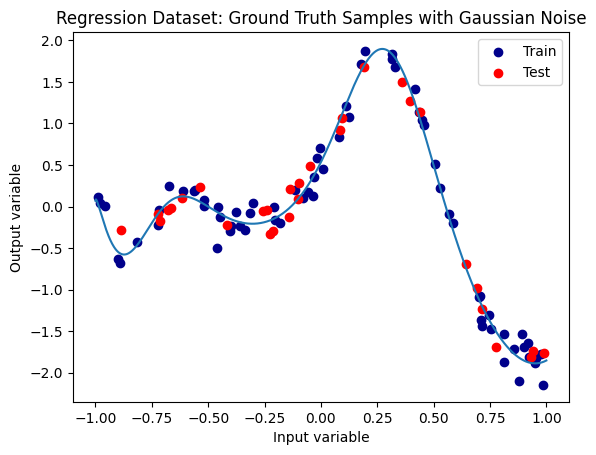

In [56]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

def generate_dataset(size=100, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)


xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
x_tr, x_te, y_tr, y_te = generate_dataset()

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

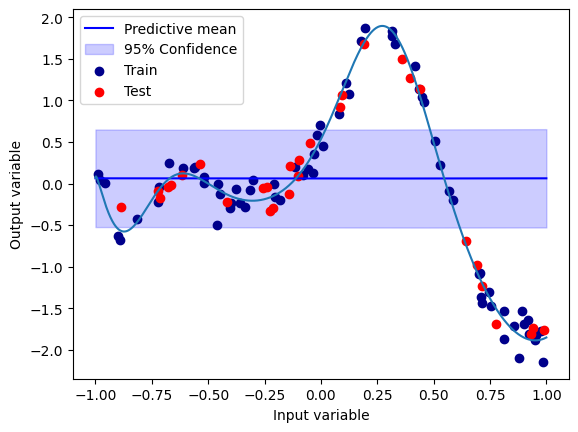

In [63]:

net = FullCovGaussianNetwork(layer_sizes=[1, 2, 2, 1], prior_std=0.3, init_std=0.1, alpha=0.01, gamma=1)

def to_numpy(x):
    return x.detach().cpu().numpy() # convert a torch tensor to a numpy array

def plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net, n_samples=100):
    n_test = xs.shape[0]
    predictions = np.zeros((n_samples, n_test))

    for i in range(n_samples):
        params_sample = net.sample_params()
        predictions[i,] = to_numpy(net.forward(torch.tensor(xs, dtype=torch.float32).unsqueeze(1), params_sample).flatten())

    pred_mean = predictions.mean(0)
    pred_std = predictions.std(0)

    x_tr, x_te = to_numpy(x_tr).flatten(), to_numpy(x_te).flatten()
    y_tr, y_te = to_numpy(y_tr).flatten(), to_numpy(y_te).flatten()

    plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
    plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')
    plt.plot(xs, ys)
    plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
    plt.scatter(x_te, y_te, label='Test', color='red')
    plt.xlabel('Input variable')
    plt.ylabel('Output variable')
    plt.legend()
    plt.show()

    
    ############### continue plotting here ###############

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=net, n_samples=100)

Epoch 1
Parameter containing:
tensor([-0.0453,  0.0454, -0.0508,  0.0534,  0.0103,  0.1371,  0.0046,  0.0622,
         0.3155,  0.1445, -0.6336, -0.8252, -0.5079])
Epoch 2
Parameter containing:
tensor([-1.5910e+01, -6.3884e+03,  3.7859e+01,  1.5668e+04, -6.8960e+01,
         2.6470e+03, -1.3276e+02,  5.0045e+03,  1.2041e+04,  1.6056e+04,
        -1.3137e+04, -2.8287e+03, -5.2903e+03])
Epoch 3
Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Epoch 4
Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Epoch 5
Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Epoch 6
Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Epoch 7
Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Epoch 8
Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

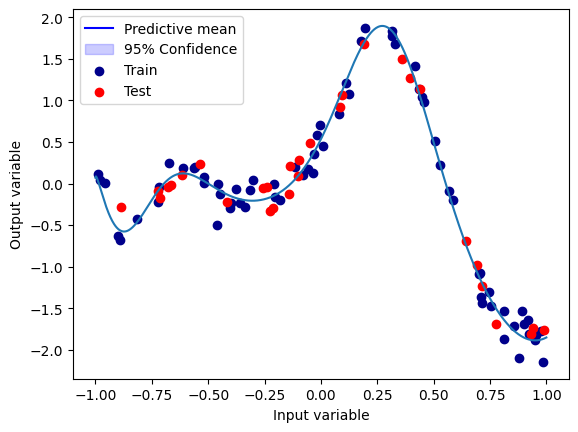

In [58]:

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 10

for epoch in range(n_epochs):

    print(f'Epoch {epoch+1}')
    update_variational_params(net, x_tr, y_tr, noise=0.1, K=1)

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=net, n_samples=1)



In [ ]:
def update_variational_params_choldate(net, input, targets, noise=1, K=100):
    n = net.num_params
    g = compute_g(net, input, targets, K, noise).unsqueeze(1) # I think this is ok but it's possible it's updating in the wrong direction
    # print(g)
    with torch.no_grad():
        mu, chol = net.mean.unsqueeze(1), net.cov_chol
        
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)
        alpha_prime = torch.tensor([1 / (1-alpha*gamma)])
        
        v = alpha_prime * chol @ (chol.t() @ g)

        beta = - alpha / (1 + alpha * g.t() @ v)
        beta = beta.item()
        chol = torch.sqrt(alpha_prime) * chol
        
        chol_tf = tf.convert_to_tensor(chol.numpy())
        v_tf = tf.convert_to_tensor(v.numpy())
        v_tf = tf.reshape(v_tf, [13])  # Shape (13,)

        chol_updated_tf = tfp.math.cholesky_update(chol_tf, v_tf, multiplier=beta)
        chol_updated = torch.from_numpy(chol_updated_tf.numpy())

        
        

        omega = v.detach().clone()
        b = 1 
        chol_new = torch.zeros(n,n)
        for j in range(n):
            chol_new[j,j] = torch.sqrt(alpha_prime * chol[j,j]**2 + beta/b * omega[j]**2)
            xi = alpha_prime * chol[j,j]**2 * b + beta * omega[j]**2
            for k in range(j,n):
                omega[k] = omega[k] - omega[j]/chol[j,j] * torch.sqrt(alpha_prime) * chol[k,j]
                chol_new[k,j] = torch.sqrt(alpha_prime) * chol_new[j,j]/chol[j,j] * chol[k,j] + chol_new[j,j] * beta * omega[j]/xi * omega[k]

            b = b + beta * omega[j]**2/(alpha_prime * chol[j,j]**2)




        nu = g.t() @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * g
    net.lambda_1 = nn.Parameter(lambda_1.flatten(), requires_grad=False)
    net.mean = nn.Parameter(((chol_new @ chol_new.t())@lambda_1).flatten(), requires_grad=False) # might need to be true
    # print(net.mean)
    net.cov_chol = nn.Parameter(chol_new, requires_grad = False) # same here
    return net.cov_chol, chol_updated, give_me_sigma(chol,g,alpha,gamma)


Epoch 1
(13,)
Parameter containing:
tensor([ 0.2490,  0.0224,  0.3655, -0.0336, -0.0925, -0.0017,  0.6744,  0.0131,
        -0.3625,  1.6576, -0.1419, -1.0165, -1.5532])
Epoch 2
(13,)
Parameter containing:
tensor([ 2.1944e+05,  2.5131e+04,  1.7218e+06, -2.6199e+05,  2.1809e+03,
         8.4081e+02,  1.1124e+06,  3.7790e+05,  2.5789e+03,  1.1360e+06,
         6.1062e+03, -1.5338e+06, -1.1033e+06])
Epoch 3
(13,)
Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Epoch 4
(13,)
Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Epoch 5
(13,)
Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Epoch 6
(13,)
Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Epoch 7
(13,)
Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Epoch 8
(13,)
Parameter containing:
tensor([nan, n

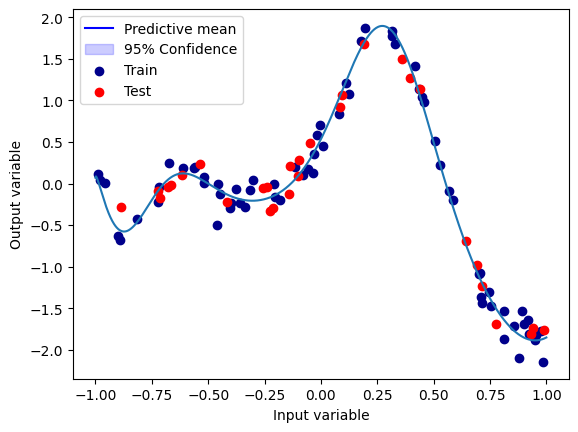

In [64]:

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 10

for epoch in range(n_epochs):

    print(f'Epoch {epoch+1}')
    update_variational_params_choldate(net, x_tr, y_tr, noise=0.1, K=1)
    print(net.mean)
plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=net, n_samples=1)


In [190]:
chol - chol_other

tensor([[ 3.0456e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-6.4281e-07,  3.0456e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.9316e-06,  6.3591e-07,  3.0456e-03,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-2.6207e-06,  8.6278e-07,  2.5926e-06,  3.0456e-03,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.4394e-06, -4.7386e-07, -1.4239e-06, -1.9319e-06,  3.0456e-03,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.549

In [ ]:
# collect the kl divergence for all MFVILinear layers
def kl_divergence(net):
   
    return net.kl_divergence()

# define the training function which minimises the negative ELBO
# note that the (tempered) negative ELBO = negative log-likliehood of dataset + beta * KL
# where the neg. log-likelihood *per datapoint* is computed with a function
# nll = data_loss_func(y, y_pred)
# this data_loss_func is to be defined later, depending on the learning task
def train_step(net, opt, data_loss_func, dataloader, N_data, beta=1.0):
    for _, (x, y) in enumerate(dataloader):
        x = x.to(device); y = y.to(device)
        opt.zero_grad() # opt is the optimiser
        y_pred = net(x)
        ### begin of your code ###
        # notice we might use mini-batches, so be careful for the right data-count!

        nll = data_loss_func(y, y_pred).mean()
        kl = kl_divergence(net)
        loss = N_data * nll + beta * kl
    

        ### end of your code ###

        loss.backward()
        opt.step()
    return nll, kl

def train_step_new(net, data_loss_func, dataloader, N_data, beta=1.0, k=10):
    for _, (x, y) in enumerate(dataloader):
        x = x.to(device); y = y.to(device)

        # Forward pass to compute predictions
        y_pred = net(x)
        
        # Compute negative log-likelihood and KL divergence
        nll = data_loss_func(y, y_pred).mean()
        kl = kl_divergence(net)

        # Compute the gradient with respect to sampled parameters
        g = compute_gradient(net, x, y, k)  # k is the number of samples to compute gradient mean
        grad_mean = g.mean(dim=1)  # Average gradient across samples

        # Manual updates for mu and sigma
        net.mean, net.scale_tril = update_params(net.mean, net.scale_tril, grad_mean)  # Update sigma
        net.mu = update_mu(net.mu, grad_mean)  # Update mu

    return nll, kl


def update_params(mean, chol, grad):
    '''Need to initialise lambda somewhere...surely this is learnable? can i not do a rank 1 update to cholesky? So I don't need to do sigma = chol * chol^T'''
    alpha = 1e-3
    gamma = 1
    sigma = chol @ chol.t()
    factor = torch.sqrt(torch.tensor(1/(1-alpha*gamma)))
    
    chol = factor * chol
    # sigma = torch.matmul(chol, torch.transpose(chol, 0, 1))
    # sigma_tild = 1/(1-alpha*gamma) *sigma
    sigma_g = sigma_tild @ grad
    # sigma_g = torch.matmul(sigma_tild , grad)
    # sigma = sigma_tild - alpha* torch.matmul(sigma_tild, torch.transpose(sigma_tild, 0, 1))/(1+alpha* torch.matmul(torch.transpose(grad),sigma_g))
    sigma = sigma_tild - alpha * sigma_g @ sigma_g.t() / (1+alpha* grad.t() @ sigma_g)
    # nu = torch.matmul(torch.transpose(grad),mean)
    nu = grad.t() @ mean
    lambda_1 = (1-alpha*gamma)*lambda_1 - alpha(1-nu)*grad
    # mean = torch.matmul(sigma,lambda_1)
    mean = chol @ (chol.t() @ lambda_1)
    # mean = sigma @ lambda_1

# now define the data_loss_func that will be used later
# in detail, we will define a Gaussian log-likelihood function below, and then define
# data_loss_func = lambda y, y_pred: -gauss_loglik(y, y_pred, log_noise_var)
# where log_noise_var is the output noise (log) variance which is a seperate model parameter
# define gaussian log-likelihood
def gauss_loglik(y, y_pred, log_noise_var):
    # y should have shape as (batch_size, y_dim)
    # y_pred should have shape as (batch_size, y_dim) or (K, batch_size, y_dim)
    # where K is the number of MC samples
    # this function should return per-data loss of shape (batch_size,) or (K, batch_size)
    ### begin of your code ###
    # hint: consult with your textbook or wikipedia for the Gaussian distribution form
    l2_dist = (y-y_pred).pow(2).sum(-1)
    ll = -0.5 * (log_noise_var + math.log(2*math.pi) + l2_dist * torch.exp(-log_noise_var))

    ### end of your code ###
    return ll

# define the prediction function with Monte Carlo sampling using K samples
def predict(bnn, x_test, K=1):
    y_pred = []
    for _ in range(K):
        y_pred.append(bnn(x_test))
    # shape (K, batch_size, y_dim) or (batch_size, y_dim) if K = 1
    return torch.stack(y_pred, dim=0).squeeze(0)

# define the error metrics: RMSE and test negative log-likelihood
# in below functions y_pred should have shape (K, batch_size, y_dim) or (batch_size, y_dim)
def rmse(y, y_pred):
    if len(y_pred.shape) > 2: # using K > 1 MC samples
        y_pred = y_pred.mean(0)
    return (y - y_pred).pow(2).sum(-1).mean().sqrt()

def test_nll(y, y_pred, data_loss_func):
    nll = data_loss_func(y, y_pred)  # with shape (batch_size) or (K, batch_size)
    if len(nll) == 2:  # using K > 1 MC samples
        nll = -torch.logsumexp(-nll, dim=0) + math.log(nll.shape[0]) # Bayesian predictive average
    return nll.mean()

### Training